<font face="微软雅黑" size=6 color=#000000> Q4

In [4]:
import pandas as pd
import numpy as np
from numpy import dot
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import json
import random
import re
import os
import sys
import math
import csv
import pickle
import string

import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec

from collections import Counter
from string import digits

/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


<font face="微软雅黑" size=6 color=#000000> 1. Prepare relevant docs 

In [1159]:
# load claims
def load_dataset_json(path, instance_num=1e6):
    """
    Reads the Fever Training set, returns list of examples.
    instance_num: how many examples to load. Useful for debugging.
    """
    data = []
    with open(path, 'r') as openfile:
        for iline, line in enumerate(openfile.readlines()):
            data.append(json.loads(line))
            if iline+1 >= instance_num:
                break
    return data
path_windows = "N:\\DesktopSettings\\Desktop\\DM_working\\dataset\\train.jsonl"
path_mac = "/Users/cengqiqi/Desktop/DM_working/dataset/train.jsonl"
dataset = load_dataset_json(path=path_mac, instance_num=1500)

claims = []
for i in dataset:
    if i['verifiable'] == 'VERIFIABLE':
        claims.append(i)
        
# load doc
path_windows = "N:\\DesktopSettings\\Desktop\\DM_working\\dataset\\wiki_id_text"
path_mac = "/Users/cengqiqi/Desktop/DM_working/dataset/wiki_id_text"
wikipage = pd.read_table(path_mac,header = None)

with open('inverted_word_dictionary.txt', 'rb') as handle:
    inverted_word_dictionary = pickle.loads(handle.read())
    
with open("doc_length_list.txt", "rb") as fp:   # Unpickling
    doc_length_list = pickle.load(fp)

In [754]:
# methods to get the relevant documents (which are the same methods with that in Q2)

def claimProcess(words):
    #######  lower case  ############################################################
    words = words.lower()
    
    ####### tokenize ###############################################################
    pattern = r"""(?x)                  
                          (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A. 
                          |\$?\d+(?:,\d+)*(?:\.\d+)?%? # 2,000 or 2.5
                          |\w+(?:[-']\w+)*      # words w/ optional internal hyphens/apostrophe  e.g. can't
                        """
    word_list = nltk.regexp_tokenize(words, pattern)
    
    ####### remove stop words #######################################################
    stopwordlist = set(stopwords.words('english'))
    word_list = [w for w in word_list if w not in stopwordlist]
   
    ####### lemmatize ################################################################
    word_list = [WordNetLemmatizer().lemmatize(w,pos = 'v') for w in word_list] # only Lancaster
    

    return word_list 

total_words = 289459793
ave_length = 54

def DirichletSmoothing(claim_wordlist):
    
    word_count_in_collection = []
    for word_c in claim_wordlist:
        if word_c in inverted_word_dictionary:
            word_count_in_collection.append(np.sum(list(inverted_word_dictionary[word_c].values()))) 
        else:
            word_count_in_collection.append(0.00000000000000000001) 
            
    p_for_doc_list = []
    for i in range(len(doc_length_list)):
        logp = 0
        for j in range(len(claim_wordlist)): 
            if doc_length_list[i]:
                word_count_in_doc = inverted_word_dictionary[claim_wordlist[j]]["doc" + str(i)] if claim_wordlist[j] in inverted_word_dictionary and "doc" + str(i) in inverted_word_dictionary[claim_wordlist[j]] else 0
                temp1 = (doc_length_list[i]/(doc_length_list[i]+ave_length))*(word_count_in_doc/doc_length_list[i])
            else:
                temp1 = 0
            temp2 = (ave_length/(doc_length_list[i]+ave_length))*(word_count_in_collection[j]/total_words)
            temp = temp1 + temp2
            logp = logp+math.log(temp)
      
        p_for_doc_list.append(math.pow(math.e,logp))
        
                
    return p_for_doc_list

# # get the top 5 doc id for a single claim
def getTop5(p_for_doc_list):

    top_5_idx = np.argsort(p_for_doc_list)[-5:][::-1]
    
    return top_5_idx

In [57]:
# get the top 5 relevant documents for the first 1000 claims (this cost around 15 hours)
# write the results to q4_docs.csv

for i in tqdm(range(0,1000)):
    
    claim_wordlist = claimProcess(claims[i]['claim'])
    p_for_doc_list = DirichletSmoothing(claim_wordlist)
    doc_id = getTop5(p_for_doc_list)

    with open('q4_docs.csv', "a", newline='') as config_csv:
        
        list_save = [claims[i]['id']]
        list_save.extend(wikipage[0][doc_id])
        
        writer = csv.writer(config_csv)
        writer.writerow(list_save)

In [56]:
claims[599]

{'id': 92830,
 'verifiable': 'VERIFIABLE',
 'label': 'SUPPORTS',
 'claim': 'Kurt Angle won a gold medal in freestyle wrestling at the 1995 World Wrestling Championships.',
 'evidence': [[[110143, 123773, 'Kurt_Angle', 3]]]}

<font face="微软雅黑" size=6 color=#000000> 2. *Import Data and Models

In [5]:
#load claims
def load_dataset_json(path, instance_num=1e6):
    """
    Reads the Fever Training set, returns list of examples.
    instance_num: how many examples to load. Useful for debugging.
    """
    data = []
    with open(path, 'r') as openfile:
        for iline, line in enumerate(openfile.readlines()):
            data.append(json.loads(line))
            if iline+1 >= instance_num:
                break
    return data
path_windows = "N:\\DesktopSettings\\Desktop\\DM_working\\dataset\\train.jsonl"
path_mac = "/Users/cengqiqi/Desktop/DM_working/dataset/train.jsonl"
dataset = load_dataset_json(path=path_mac, instance_num=1500)

claims = []
for i in dataset:
    if i['verifiable'] == 'VERIFIABLE':
        claims.append(i)
        

In [6]:
# load relevant docs (which is got from 1. Prepare relevant docs  )
with open('q4_docs.csv', 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    doc_list = []
    for row in reader:
        doc_list.append(row)
doc_dict = {line[0]:line[1:] for line in doc_list}

In [7]:
# load docs id and text
path_windows = "N:\\DesktopSettings\\Desktop\\DM_working\\dataset\\wiki_id_text"
path_mac = "/Users/cengqiqi/Desktop/DM_working/dataset/wiki_id_text"
wikipage = pd.read_table(path_mac,header = None)

In [8]:
# load docs lines ()
# format: doc_lines['Alphabetical_list_of_comunes_of_Italy'][1]

def parse_wiki(wikipedia_dir):

    # doc_id_text saves the title and content of each wiki-page
    doc_id_text=dict()

    for i in tqdm(range(1,110)):# jsonl file number from 001 to 109
        jnum="{:03d}".format(i)
        fname=wikipedia_dir+"wiki-"+jnum+".jsonl"
        with open(fname) as f:
            # point=f.tell()# file pointer starting from 0
            line=f.readline()
            while line:
                data=json.loads(line.rstrip("\n"))
                doc_id=data["id"] 
                text = data["text"]
                lines=data["lines"]
                if text != "":
                    doclines = {}
                    for l in lines.split("\n"):
                        fields = l.split("\t")
                        if fields[0].isnumeric():
                            l_id = int(fields[0])
                            l_txt = fields[1]
                            doclines[l_id] = l_txt

                    doc_id_text[doc_id]=doclines
                # point=f.tell()
                line=f.readline()

    return doc_id_text

wikipedia_dir = '/Users/cengqiqi/Desktop/DM_working/dataset/wiki-pages/wiki-pages/'

doc_lines = parse_wiki(wikipedia_dir)

In [9]:
# # some docs lines are not a complete sentence
# for x in doc_lines:
#     if len(doc_lines[x])>10000:
#         print(x)
        
# doc_lines['List_of_Wales_national_rugby_union_players']

<font face="微软雅黑" size=6 color=#000000> 3. Negative Sampling

In [22]:
# for a single claim, get the positive and negative samples
def posNegSampleListForAClaim(i,k,doc_dict,claims):
    '''
    this function helps to return a list in [positive_sentence_list,negative_sentence_list]
    the parameter is the number of claims that you want to search on
    '''
    # for claim i, the positive sentence and negative sentence are showed below
    
    ### positive sentence
    # positive_sentence_list = [[evi[2],evi[3]] for evi in np.array(claims[i]['evidence']).reshape(-1,4)]
    positive_sentence_list = []
    for cla_1 in claims[i]['evidence']:
        for cla_2 in cla_1:
            positive_sentence_list.append([cla_2[2],cla_2[3]])
            
    # remove duplicated sample
    positive_sentence_list = [list(i) for i in set(tuple(i) for i in positive_sentence_list)]

    
    
    ### negative sample
    relevent_docs = doc_dict[str(claims[i]['id'])]
    
    temp_negative_sentence_list = []
    for title in relevent_docs:
        for sentence in doc_lines[title].keys():
            if len(doc_lines[title][sentence]) > 0 and doc_lines[title][sentence][-1] in string.punctuation: # sample cannot be '', and it need to be ended by punctuation
                temp_negative_sentence_list.append([title, sentence])
            
    for remove_pos_sentence in positive_sentence_list:
        if remove_pos_sentence in temp_negative_sentence_list:
            temp_negative_sentence_list.remove(remove_pos_sentence)
            
    negative_sentence_list = random.sample(temp_negative_sentence_list, min(k*len(positive_sentence_list),len(temp_negative_sentence_list)))

    
#     while len(negative_sentence_list) < len(positive_sentence_list)*7:
        
# #         title = random.choice(relevent_docs)
# #         random_key = random.choice(list(doc_lines[title].keys()))
# #         rand_item = items[random.randrange(len(items))]
        
#         title = relevent_docs[random.randrange(len(relevent_docs))]
#         avalible_sentence = list(doc_lines[title].keys())
#         random_key = avalible_sentence[random.randrange(len(avalible_sentence))]

#         if len(doc_lines[title][random_key]) > 0:
#             negative_sentence = [title,random_key]
#             if (negative_sentence not in positive_sentence_list) and (negative_sentence not in negative_sentence_list):
#                 negative_sentence_list.append(negative_sentence)

    return [positive_sentence_list,negative_sentence_list]

In [23]:
# apply the posNegSampleListForAClaim to all claims
def getSampleList(claims, sample_num,k,doc_dict):
    '''
    this function will return the positive sentences and negative sentences of the first 1000 verifiable claims
    in format [[claim_id, positive_sentence, negative_sentence],...]
    '''
    pos_neg_sample_1000 = []
    for i in tqdm(range(sample_num)):
        temp = [claims[i]['id']]
        temp.extend(posNegSampleListForAClaim(i,k,doc_dict,claims))
        pos_neg_sample_1000.append(temp)
    
    return pos_neg_sample_1000
   
pos_neg_sample_1000 = getSampleList(claims, 1000, 1,doc_dict)

In [58]:
# save the results
with open('1000_sample_k1_train', 'wb') as f:
    pickle.dump(pos_neg_sample_1000, f)

In [590]:
# with open('1000_sample') as f:
#     print(pickle.load(f))

In [270]:
# for claim_sample in pos_neg_sample_1000_train[1:100]:
#     for sentence in claim_sample[2]:
#         print(doc_lines[sentence[0]][sentence[1]])
#         print(' ')

In [158]:
# pos_neg_sample_1000

<font face="微软雅黑" size=6 color=#000000> 4.* Sentence Embedding

In [10]:
# import glove model 
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model
glove_model = loadGloveModel("/Users/cengqiqi/Desktop/DM_working/glove/glove.42B.300d.txt")


### this glove_model will be updated in sumPooling() method below

Loading Glove Model
Done. 1917494  words loaded!


In [11]:
# process the sentence (to a word list before embedding)
def sentenceProcess(sentence):
    #######  lower case  ############################################################
    sentence = sentence.lower()
    
    ####### tokenize ###############################################################
    pattern = r"""(?x)                  
                          (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A. 
                          |\$?\d+(?:,\d+)*(?:\.\d+)?%? # 2,000 or 2.5
                          |\w+(?:[-']\w+)*      # words w/ optional internal hyphens/apostrophe  e.g. can't
                        """
    word_list = nltk.regexp_tokenize(sentence, pattern)
    
    
    ####### remove rrb #############################################################
#     for word in word_list:
#         if word in ['rrb', 'lrb','lsb','rsb']:
#             word_list.remove(word)
    
    ### do not remove stopwords in this case
    ####### remove stop words #######################################################
#     stopwordlist = set(stopwords.words('english'))
#     word_list = [w for w in word_list if w not in stopwordlist]
   
    ####### lemmatize ################################################################
    word_list = [WordNetLemmatizer().lemmatize(w,pos = 'v') for w in word_list] # only Lancaster
    
    return word_list 

In [12]:
# convert words to vectors and sum pooling
def sumPooling(sentence):
    
    #you need to set a threshold filtering out less frequent words or set these out-of-vocabulary words as a special symbol.
    
    words_list = sentenceProcess(sentence)
    sentence_vector = np.zeros(len(glove_model['i']),) 
    
    count = 0
    for word in words_list:
        if word in glove_model:
            v = glove_model[word]
            count += 1
        else:
            # if word not in glove model, update glove model
            embedding_model = Word2Vec([[word]], size=300, window=5, min_count=1, workers=2)
            additional_word = {w: vec for w, vec in zip(embedding_model.wv.index2word, embedding_model.wv.vectors)}
            glove_model.update(additional_word)
            v = glove_model[word]
        sentence_vector += v
        
    return sentence_vector

# # convert words to vectors and sum pooling
# def sumPooling(sentence):
    
#     #you need to set a threshold filtering out less frequent words or set these out-of-vocabulary words as a special symbol.
    
#     words_list = sentenceProcess(sentence)
#     sentence_vector = np.zeros(len(glove_model['i']),) 
    
#     count = 0
#     for word in words_list:
#         if word in glove_model:
#             v = glove_model[word]
#             count += 1
#         else:
#             v = sentence_vector
#         sentence_vector += v
#     return sentence_vector

In [13]:
np.zeros(len(glove_model['i']),).shape

(300,)

In [14]:
# load sentence sample (which is got from 3. Negative Sampling)
f = open('1000_sample_k1_train','rb')
pos_neg_sample_1000_train = pickle.load(f)
f.close()

In [16]:
# prepare input, change sentence sample to input vectors
def prepareInput(claims, pos_neg_sample):
    
    claim_m = np.empty((0,len(glove_model['i'])), int)
    sentence_m = np.empty((0,len(glove_model['i'])), int)
    input_y = np.empty((0,1),int)

    for i in tqdm(range(len(pos_neg_sample))):
        sample = pos_neg_sample[i]

        if sample[0] == claims[i]['id']: # ensure the same row

            # claim
            claim_v = sumPooling(claims[i]['claim'])

            # positive sentence
            for pos in sample[1]:
                try:
                    pos_v = sumPooling(doc_lines[pos[0]][pos[1]])
                except:
                    print(f'the positive sentence {pos[1]} in {pos[0]} is skipped due to some problems')
                else:
                    claim_m = np.append(claim_m, claim_v[np.newaxis], axis=0)
                    sentence_m = np.append(sentence_m,pos_v[np.newaxis], axis=0)
                    input_y = np.append(input_y,[[1]], axis=0)
            # negative sentence    
            for neg in sample[2]:
                try:
                    neg_v = sumPooling(doc_lines[neg[0]][neg[1]])
                except:
                    print(f'the negative sentence {neg[1]} in {neg[0]} is skipped due to some problems')
                else:
                    claim_m = np.append(claim_m, claim_v[np.newaxis], axis=0)
                    sentence_m = np.append(sentence_m,neg_v[np.newaxis], axis=0)
                    input_y = np.append(input_y,[[0]], axis=0)
                  
        input_x = np.concatenate((claim_m, sentence_m), axis=1)  #10*100
        #input_x = claim_m+sentence_m
        
    input_y = np.squeeze(input_y)
    
    return [input_x, input_y]


input_x, input_y = prepareInput(claims, pos_neg_sample_1000_train)

print(input_x.shape)
print(input_y.shape)

the positive sentence 0 in José_María_Chacón is skipped due to some problems
the positive sentence 0 in Régine_Chassagne is skipped due to some problems
the positive sentence 0 in Chris_Pérez is skipped due to some problems
the positive sentence 24 in Chris_Pérez is skipped due to some problems
the positive sentence 15 in Beyoncé is skipped due to some problems
the positive sentence 16 in Beyoncé is skipped due to some problems
the positive sentence 0 in Frédéric_Auguste_Bartholdi is skipped due to some problems
(3833, 600)
(3833,)


<font face="微软雅黑" size=6 color=#000000> 5. *Logistic Regression

In [430]:
# #Logistic Regression Model without learning rate (using Second-order minimization)

# This is not applicable to this question cause we need to discuss the impact of learning rate

# # sigmoid
# def sigmoid(z):
#     return 1/(np.exp(-z) + 1)
 
# # R for hessian matrix
# def R(input_x, theta):
#     '''This function will return the R for Hessian matrix '''
#     diag_R = list(range(input_x.shape[0]))
#     for i in range(input_x.shape[0]):
#         diag_R[i] = float(sigmoid(input_x[i]@theta)*(1-sigmoid(input_x[i]@theta)))
#     R = np.diag(diag_R)
#     return R

# def norm(w):
#     return np.sqrt(np.dot(w.T,w))   

# def LRmodel(input_x, input_y, initial_theta, alpha, num_iters):
    
#     input_y = np.squeeze(input_y)
    
#     # Gradient Descent
#     J_history = []
#     theta = initial_theta
#     current_iter = 0
#     for iter in tqdm(range(num_iters)):
        
#         current_iter+=1
        
#         # cost J and grad
#         m = input_x.shape[0]
#         hx = sigmoid(input_x@theta)
#         J = -1/m*np.sum(input_y*np.log(hx) + (1-input_y)*np.log(1-hx),axis=0) 
        
#         grad = 1/m*(input_x.T@(hx-input_y))
#         hessian = input_x.T@R(input_x, theta)@input_x

#         # update theta
#         theta_new = theta - np.linalg.inv(hessian)@grad
#         if norm(theta_new - theta) < 0.001*norm(theta_new):
#             break
#         else:
#             theta = theta_new
            
#         J_history.append(J)
        
#     return [theta, J_history, current_iter]

In [17]:
#Logistic Regression Model

# sigmoid
def sigmoid(z):
    return 1./(1.+ np.exp(-z))

# feature normalization
def normalization(input_x):

    mean_100 = np.mean(input_x, axis = 0)
    max_100 = np.std(input_x, axis = 0)

    x_normolized = (input_x-mean_100)/max_100
    
    return x_normolized


def LRmodel(input_x, input_y, initial_theta, alpha, num_iters):
    
    input_x = normalization(input_x)
    
    # Gradient Descent
    J_history = []
    theta = initial_theta
    current_iter = 0
    for iter in tqdm(range(num_iters)):
        
        # count iteration
        current_iter += 1
        
        # get the total input length and call sigmoid function
        m = input_x.shape[0]
        hx = sigmoid(input_x@theta)
        
        # cost J (avoid overflow of exp() )
        #J = -1/m*(np.sum(input_y*np.log(hx)+(1-input_y)*np.log(1-hx),axis=0))
        x = input_x@theta
        mask_pos = x>=0
        mask_neg = x<0
        x_pos = x*mask_pos
        x_neg = x*mask_neg

        J_posx = 1/m*(np.log(1+np.exp(-x_pos)) + (1-input_y)*x_pos)*mask_pos
        J_negx = 1/m*(np.log(np.exp(x_neg)+1)-input_y*x_neg)*mask_neg
        J = np.sum(J_posx + J_negx) + 1/(2*m)*np.dot(theta, theta)### regularization

        # grad
        grad = 1/m*(input_x.T@(hx-input_y)) + 1/m*theta ### regularization
           
        # update theta
        theta = theta - alpha*grad
        
        # break when there is only little decrease in cost
        if J_history and abs(J_history[-1] - J)< 0.00000001:
            break
            
        J_history.append(J)
        
    return [theta, J_history, current_iter]

In [670]:
# train the models and get results
alpha = 0.1
initial_theta = np.zeros(input_x.shape[1], int)
num_iters = 10000

# train model
theta, J_history, current_iter= LRmodel(input_x, input_y, initial_theta, alpha, num_iters)

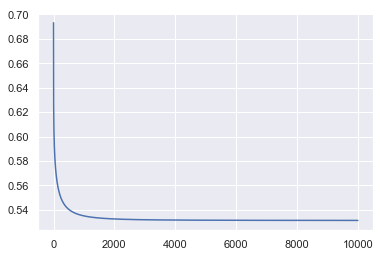

In [671]:
# visualisation for cost J
plt.plot(J_history)

In [614]:
# top5 = np.argsort(prediction_y)[-5:][::-1]
# relevent_bool = np.array((prediction_y > 0.5), dtype=int)

# # to calculate accuracy, compare prediction_y and validation_y

<font face="微软雅黑" size=6 color=#000000> 6. *Evaluation

In [19]:
# import validation claims
path_windows = "N:\\DesktopSettings\\Desktop\\DM_working\\dataset\\dev.jsonl"
path_mac = "/Users/cengqiqi/Desktop/DM_working/dataset/dev.jsonl"
dataset = load_dataset_json(path=path_mac, instance_num=20)

claims_dev = []
for i in dataset:
    if i['verifiable'] == 'VERIFIABLE':
        claims_dev.append(i)
claims_dev = claims_dev[0:10]

In [20]:
# # get relavent docs for 10 dev claims

# for i in tqdm(range(10)):
    
#     claim_wordlist = claimProcess(claims_dev[i]['claim'])
#     p_for_doc_list = DirichletSmoothing(claim_wordlist)
#     doc_id = getTop5(p_for_doc_list)

#     with open('q4_relavent_docs_dev.csv', "a", newline='') as config_csv:
        
#         list_save = [claims_dev[i]['id']]
#         list_save.extend(wikipage[0][doc_id])
        
#         writer = csv.writer(config_csv)
#         writer.writerow(list_save)

with open('q4_relavent_docs_dev.csv', 'r',encoding="utf-8") as f:
    reader = csv.reader(f)
    doc_dev = []
    for row in reader:
        doc_dev.append(row)
dev_dict = {line[0]:line[1:] for line in doc_dev}

In [24]:
# get all the avaliable sentence in validation set (no nagative sampling)
def allPotentialSentenceForADoc(i,dev_dict,claims_dev):
    '''
    this function helps to return a list in [positive_sentence_list,negative_sentence_list]
    the parameter is the number of claims that you want to search on
    '''
    # for claim i, the positive sentence and negative sentence are showed below
    
    ### positive sentence
    # positive_sentence_list = [[evi[2],evi[3]] for evi in np.array(claims[i]['evidence']).reshape(-1,4)]
    positive_sentence_list = []
    for cla_1 in claims_dev[i]['evidence']:
        for cla_2 in cla_1:
            positive_sentence_list.append([cla_2[2],cla_2[3]])
            
    # remove duplicated sample
    positive_sentence_list = [list(i) for i in set(tuple(i) for i in positive_sentence_list)]
   
    ### negative sample
    relevent_docs = dev_dict[str(claims_dev[i]['id'])]
    
    temp_negative_sentence_list = []
    for title in relevent_docs:
        for sentence in doc_lines[title].keys():
            if len(doc_lines[title][sentence]) > 0 and doc_lines[title][sentence][-1] in string.punctuation: # sample cannot be '', and it need to be ended by punctuation
                temp_negative_sentence_list.append([title, sentence])
            
    for remove_pos_sentence in positive_sentence_list:
        if remove_pos_sentence in temp_negative_sentence_list:
            temp_negative_sentence_list.remove(remove_pos_sentence)
            
    negative_sentence_list = temp_negative_sentence_list

    return [positive_sentence_list,negative_sentence_list]

def getDevSampleList(claims_dev, sample_num,dev_dict):
    
    pos_neg_sample_1000 = []
    for i in tqdm(range(sample_num)):
        temp = [claims_dev[i]['id']]
        temp.extend(allPotentialSentenceForADoc(i,dev_dict,claims_dev))
        pos_neg_sample_1000.append(temp)
    
    return pos_neg_sample_1000

### unbalanced test data
#sample_10_dev = getDevSampleList(claims_dev,10,dev_dict)

### balanced test data
sample_10_dev = getSampleList(claims_dev, 10,1, dev_dict)

In [25]:
# embedding
validation_x, validation_y = prepareInput(claims_dev, sample_10_dev)

print('postive sample: ', sum(validation_y))
print('total sample: ', len(validation_y))

postive sample:  18
total sample:  36


In [676]:

# ### with feature normalisation

# predict on train data
predict_y_temp = sigmoid(normalization(input_x)@theta) >=0.5
predict_y = np.array(predict_y_temp, dtype=int)

# predict on dev data
predict_dev_temp = sigmoid(normalization(validation_x)@theta) >= 0.5
predict_dev = np.array(predict_dev_temp, dtype=int)


# ### without feature normalisation

# # predict on train data 
# predict_y_temp = sigmoid(input_x@theta) >=0.5
# predict_y = np.array(predict_y_temp, dtype=int)

# # predict on dev data
# predict_dev_temp = sigmoid(validation_x@theta) >= 0.5
# predict_dev = np.array(predict_dev_temp, dtype=int)


In [677]:
# accuracy (not a good measure)
# predict on train data 
temp1 = predict_y == input_y
print('Accuracy on train: ', sum(temp1)/len(input_y))

input_y
temp2 = predict_dev == validation_y
print('Accuracy on dev: ', np.sum(temp2)/len(predict_dev))

Accuracy on train:  0.7357161492303679
Accuracy on dev:  0.75


In [678]:
# test data
# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(input_x, input_y)
# predict_y = clf.predict(input_x)
# predict_dev = clf.predict(validation_x)

In [679]:
# TP, FP, TN, FN

def recallPrecisionF1(predict, actural):

    tp = sum(actural*(predict == actural))
    fp = sum(actural*(predict != actural))
    tn = sum((1-actural)*(predict == actural))
    fn = sum((1-actural)*(predict != actural))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    return [recall, precision, f1_score]

recall, precision, f1_score =  recallPrecisionF1(predict_y, input_y)
print('recall on trian: ', recall)
print('precision on train: ', precision)
print('f1 score on train: ', f1_score)
print(' ')

recall, precision, f1_score =  recallPrecisionF1(predict_dev, validation_y)

print('recall on dev: ', recall)
print('precision on dev: ', precision)
print('f1 score on dev: ', f1_score)


recall on trian:  0.7565415244596132
precision on train:  0.6945169712793734
f1 score on train:  0.7242036482439423
 
recall on dev:  0.7647058823529411
precision on dev:  0.7222222222222222
f1 score on dev:  0.7428571428571428


<font face="微软雅黑" size=6 color=#000000> 7. *Learning Rate Analysis

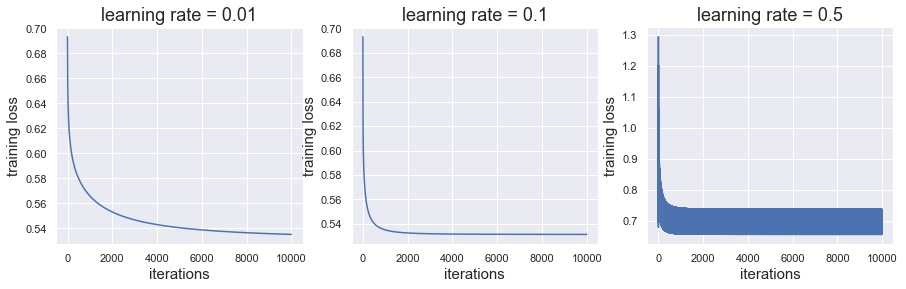

In [30]:
n = 0
sns.set(color_codes=True)
plt.figure(figsize=(15, 4))

for alpha in [0.01,0.1,0.5]:
    
    n+=1
    
    # train the models and get results
    initial_theta = np.zeros(input_x.shape[1], int)
    num_iters = 10000 #20000

    # train model
    theta, J_history, current_iter= LRmodel(input_x, input_y, initial_theta, alpha, num_iters)
    
    plt.subplot(1,3,n)
    plt.plot(J_history)
    plt.title(f'learning rate = {alpha}', fontsize=18)
    plt.xlabel('iterations', fontsize=15)
    plt.ylabel('training loss', fontsize=15)
    
    plt.savefig(os.path.join('figures', 'impact_of_learning_rate.png'), format='png', dpi=300)

<font face="微软雅黑" size=6 color=#000000>Q5

<font face="微软雅黑" size=6 color=#000000> recall, precision and F1 metrics

<font face="微软雅黑" size=6 color=#000000> on balanced data 

In [684]:
### balanced test data
sample_10_dev = getSampleList(claims_dev, 10,1, dev_dict)
validation_x, validation_y = prepareInput(claims_dev, sample_10_dev)

In [685]:
# predict on train data
predict_y_temp = sigmoid(normalization(input_x)@theta) >=0.5
predict_y = np.array(predict_y_temp, dtype=int)

# predict on dev data
predict_dev_temp = sigmoid(normalization(validation_x)@theta) >= 0.5
predict_dev = np.array(predict_dev_temp, dtype=int)


In [686]:
# accuracy (not a good measure)
# predict on train data 
temp1 = predict_y == input_y
print('Accuracy on train: ', sum(temp1)/len(input_y))

input_y
temp2 = predict_dev == validation_y
print('Accuracy on dev: ', np.sum(temp2)/len(predict_dev))

Accuracy on train:  0.7357161492303679
Accuracy on dev:  0.7777777777777778


In [687]:
# TP, FP, TN, FN

def recallPrecisionF1(predict, actural):

    tp = sum(actural*(predict == actural))
    fp = sum(actural*(predict != actural))
    tn = sum((1-actural)*(predict == actural))
    fn = sum((1-actural)*(predict != actural))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    return [recall, precision, f1_score]

recall, precision, f1_score =  recallPrecisionF1(predict_y, input_y)
print('recall on trian: ', recall)
print('precision on train: ', precision)
print('f1 score on train: ', f1_score)
print(' ')

recall, precision, f1_score =  recallPrecisionF1(predict_dev, validation_y)

print('recall on dev: ', recall)
print('precision on dev: ', precision)
print('f1 score on dev: ', f1_score)

recall on trian:  0.7565415244596132
precision on train:  0.6945169712793734
f1 score on train:  0.7242036482439423
 
recall on dev:  0.8125
precision on dev:  0.7222222222222222
f1 score on dev:  0.7647058823529411


<font face="微软雅黑" size=6 color=#000000> on unbalanced data

In [35]:
### unbalanced test data
sample_10_dev = getDevSampleList(claims_dev,10,dev_dict)
validation_x, validation_y = prepareInput(claims_dev, sample_10_dev)


print('postive sample: ', sum(validation_y))
print('negative sample: ', len(validation_y)-sum(validation_y))

postive sample:  18
negative sample:  256


In [689]:
# predict on dev data
predict_dev_temp = sigmoid(normalization(validation_x)@theta) >= 0.5
predict_dev = np.array(predict_dev_temp, dtype=int)

In [690]:
# accuracy (not a good measure)
# predict on train data 
temp1 = predict_y == input_y
print('Accuracy on train: ', sum(temp1)/len(input_y))

input_y
temp2 = predict_dev == validation_y
print('Accuracy on dev: ', np.sum(temp2)/len(predict_dev))

Accuracy on train:  0.7357161492303679
Accuracy on dev:  0.6167883211678832


In [691]:
# TP, FP, TN, FN

def recallPrecisionF1(predict, actural):

    tp = sum(actural*(predict == actural))
    fp = sum(actural*(predict != actural))
    tn = sum((1-actural)*(predict == actural))
    fn = sum((1-actural)*(predict != actural))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    return [recall, precision, f1_score]

recall, precision, f1_score =  recallPrecisionF1(predict_y, input_y)
print('recall on trian: ', recall)
print('precision on train: ', precision)
print('f1 score on train: ', f1_score)
print(' ')

recall, precision, f1_score =  recallPrecisionF1(predict_dev, validation_y)

print('recall on dev: ', recall)
print('precision on dev: ', precision)
print('f1 score on dev: ', f1_score)

recall on trian:  0.7565415244596132
precision on train:  0.6945169712793734
f1 score on train:  0.7242036482439423
 
recall on dev:  0.1282051282051282
precision on dev:  0.8333333333333334
f1 score on dev:  0.2222222222222222
